# **1. Data Loading and Exploration**

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import string
import math
import time

# Sklearn libraries for machine learning and text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Import NLTK first
import nltk

# Then import specific NLTK libraries for text processing
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Set up visualization
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # WordNet for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('averaged_perceptron_tagger')  # POS tagger for part-of-speech tagging
nltk.download('tagsets_json')  # Tagset resource
nltk.download('punkt_tab') # Tokenizer

# Define variables to store model outputs
accuracies={}
roc_auc={}

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import pandas as pd
df_train = pd.read_excel('AI_vs_huam_train_dataset.xlsx')
df_test = pd.read_csv('Final_test_data.csv')

In [3]:
df_train.head(10)

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0
5,These days the space exploration is not just a...,0
6,Regarding the suggestions that governments sho...,0
7,The ability to associate at school has been a ...,0
8,"It is true that today, people tend to give bir...",0
9,Weather to have children or not is one of the ...,0


In [4]:
df_train.describe()

,label
count,3728.000000
mean,0.500000
std,0.500067
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [5]:
df_train['essay']

,essay
0,International sports events require the most w...
1,Globalisation has become a significant aspect ...
2,There is an ever-increasing number of bullying...
3,"It is commonly believed, that companies should..."
4,Despite knowing about the adverse effects of c...
...,...
3723,I agree that successful people are willing to ...
3724,I believe that people who are open to trying n...
3725,"To succeed in life, we must do everything poss..."
3726,"I'm not entirely sure what the word ""successfu..."


In [6]:
df_train.groupby('label').describe()

essay                                                               
      count unique                                                top freq
label                                                                     
0      1864   1864  Eessential way to succeed is trying new things...    1
1      1864   1864  The key to success is trying new things while ...    1

In [7]:
df_test.head()

,essay,label
0,"Enjoyment means entertainment, satisfaction of...",NaN
1,Before to start with my opinion of the topic i...,NaN
2,"Thats a really really good subject, but acctul...",NaN
3,I disagree with the statement saying that it i...,NaN
4,It is undeniable that advertisements play a si...,NaN


In [8]:
# Compute essay length as the number of words in each essay
df_train['essay_len'] = df_train['essay'].apply(lambda x: len(x.split()))

# Print the overall average length
overall_avg = df_train['essay_len'].mean()
print("Overall average essay length (in words):", overall_avg)

# Print the average length for human-written vs AI
avg_per_label = df_train.groupby('label')['essay_len'].mean()
print("Average tweet length for human-written vs AI:")
print(avg_per_label)

Overall average essay length (in words): 279.7671673819743
Average tweet length for human-written vs AI:
label
0    299.682940
1    259.851395
Name: essay_len, dtype: float64


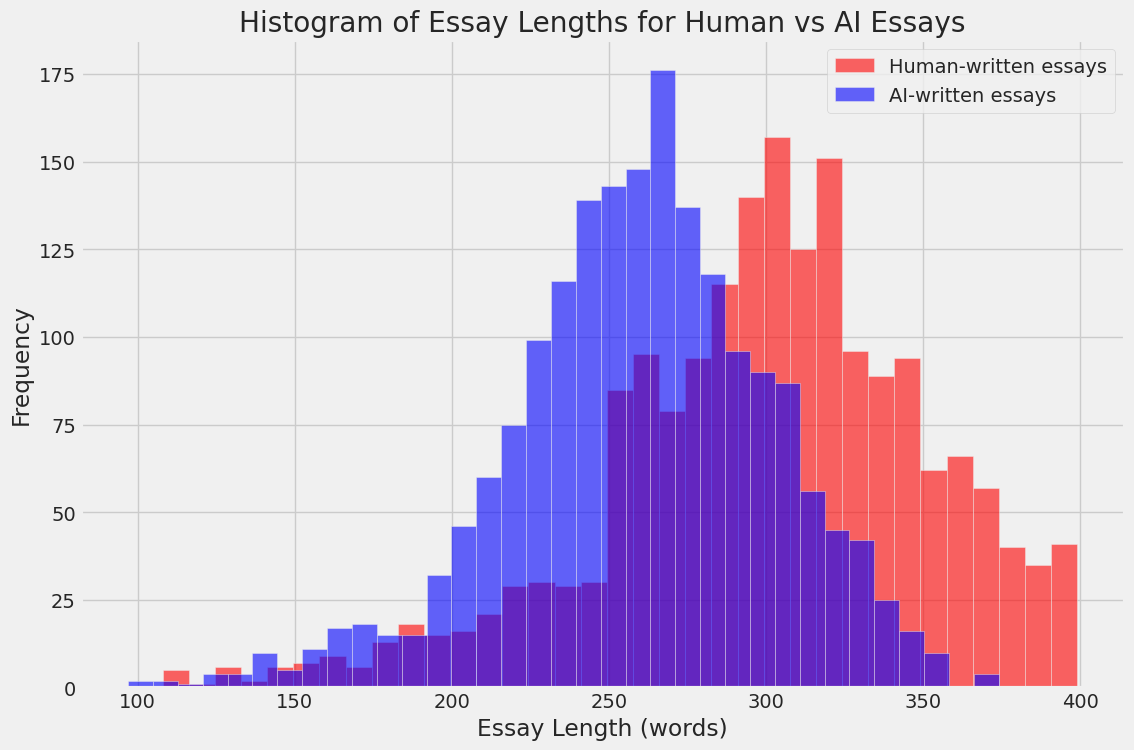

In [9]:
# Plot histograms for each label
plt.figure(figsize=(12, 8))

df_train[df_train.label == 0].essay_len.plot(
    bins=35, kind='hist', color='red', alpha=0.6, label='Human-written essays'
)
df_train[df_train.label == 1].essay_len.plot(
    bins=35, kind='hist', color='blue', alpha=0.6, label='AI-written essays'
)

plt.xlabel("Essay Length (words)")
plt.ylabel("Frequency")
plt.title("Histogram of Essay Lengths for Human vs AI Essays")
plt.legend()
plt.show()

# **2. Text Preprocessing Functions**

**2.1: Stop Words Removal**

In [10]:
 def remove_accents(input_str):
      # Normalize the string to its decomposed form (NFD)
      normalized = unicodedata.normalize('NFD', input_str)
      # Filter out the combining characters (diacritics)
      return ''.join(char for char in normalized if unicodedata.category(char) != 'Mn')

In [11]:
def text_process(essay):
    """
    Cleans and processes a string.

    This function takes a raw string and performs several text cleaning steps:
    1. Checks if the input is a string; returns an empty string otherwise.
    2. Defines a list of common English stopwords.
    3. Removes all punctuation from the string.
    4. Removes the defined stopwords from the string.
    5. Joins the remaining words back into a single cleaned string.

    Args:
        essay (str): The input string to be processed.

    Returns:
        str: The cleaned string with punctuation and stopwords removed,
             or an empty string if the input was not a string.
    """

    # Handle non-string values gracefully
    if not isinstance(essay, str):
        return ""

    # Remove accents so that "Café" becomes "Cafe", etc.
    text_no_accents = remove_accents(essay)

    # Define a set of standard English stopwords
    STOPWORDS = set(stopwords.words('english'))

    # Remove punctuation from the string
    nopunc = ''.join([char for char in text_no_accents if char not in string.punctuation])

    # Remove stopwords and join the words back into a string
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS and not word.isdigit()])

In [12]:
# Show vocab before stopword removal
train_vocab_bf = set(" ".join(df_train['essay']).split())
test_vocab_bf = set(" ".join(df_test['essay']).split())

print("=== Vocabulary statistics before stopword removal ===")
print(f"Train unique words : {len(train_vocab_bf):,}")
print(f"Test  unique words : {len(test_vocab_bf):,}")

=== Vocabulary statistics before stopword removal ===
Train unique words : 42,702
Test  unique words : 16,261


In [13]:
# Quick peek at words
print("Sample train words :", sorted(list(train_vocab_bf))[:1000], "...\n")
print("Sample test  words :", sorted(list(test_vocab_bf))[:1000], "...\n")

Sample train words : ['!', '!!', '!.', '"', '",', '".', '"10', '"2000', '"3', '"3M",', '"A', '"ABC".Eventhough', '"Abdul', '"Ahimsa"', '"Ahimsa,"', '"Aim', '"Alexa"', '"Apply"', '"Apply."', '"Arnold",', '"BE', '"Babble"(A', '"Babel"', '"Bard', '"Big', '"Bioinformatics"', '"Bourse"', '"By', '"Change', '"Charles', '"Club', '"Clubhouse"', '"Comple', '"Complete', '"Corsa",', '"Dandy', '"Divine', '"Do', '"Dolly"', '"Don\'t', '"Education', '"El', '"English', '"Euphoria."', '"Every', '"Experience', '"FAILURES', '"Failures', '"Faster,', '"Fate"', '"Father', '"Fosburry"', '"Gandhi".He', '"Get', '"Good', '"Google"', '"Google,"', '"HARDWORK', '"Harvard', '"High', '"Higher', '"Horiemon"', '"Hotmail."', '"How', '"I', '"IN', '"If', '"In', '"Innovation', '"Intel"', '"Internet', '"I‚Äôm', '"Jack', '"Knowing', '"La', '"Life', '"MOTHER"', '"Made', '"Mahatma', '"Malavoglia",', '"Men', '"Mercado', '"Mickey', '"More', '"Mother', '"Mother"', '"Mother."', '"NO', '"Never', '"New', '"Newton"', '"No', '"No",', 

In [14]:
# Apply text cleaning to the "essay" column
df_train['clean_essay'] = df_train['essay'].apply(text_process)
df_test['clean_essay'] = df_test['essay'].apply(text_process)

# Show vocab after stopword removal
train_vocab = set(" ".join(df_train['clean_essay']).split())
test_vocab = set(" ".join(df_test['clean_essay']).split())

print("=== Vocabulary statistics after stopword removal ===")
print(f"Train unique words : {len(train_vocab):,}")
print(f"Test  unique words : {len(test_vocab):,}")

=== Vocabulary statistics after stopword removal ===
Train unique words : 26,394
Test  unique words : 10,771


In [15]:
# Quick peek at words
print("Sample train words :", sorted(list(train_vocab))[:1000], "...\n")
print("Sample test  words :", sorted(list(test_vocab))[:1000], "...\n")

Sample train words : ['100inch', '100meter', '100mts', '100th', '10year', '12yearold', '14th', '14thcentury', '15th', '15whileother', '16m', '1800s', '18th', '18thcentury', '1900s', '1920s', '1923in', '1930s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th', '1hrthis', '1paragraph', '1st', '1v1', '1‚aibut', '2000s', '200in', '200meter', '200mts', '20s', '20th', '20years', '21st', '2426c', '2426¬∞c', '2hour', '2nd', '30000ayear', '30s', '30year', '35s', '3d', '3italia', '3italia‚aos', '3m', '3questions', '3r', '40s', '40year', '4c', '4m', '4s', '4¬∞c', '500kg', '50hes', '50s', '50sp', '5g', '5th', '5the', '60s', '60throusanddollar', '66megawatt', '70s', '7th', '7‚au', '80s', '90minute', '90s', '90th', '95‚aihow', '982000mexpand', '99th', 'aa', 'aaaas', 'aaiaa©„aaaπaa¥∞„a´aa∂e≥a„cie¶≥aøu„ao„a¶„an„an„c≥„e≥„ea„c£„c∑„eß„e≥„ci‰øu„a§„ai„a®„aæa§ßaaa„ai„ciau•„ca„ac„au„ca„aø‰∫∫„a´„ccao±eao„ao„a¶„an„ca„au„ca„aa‰∏ne©±„cieao„ao„a¶e¶™„a´aøæ„ao„caenue¨u„cn„aaaea‰∫∫„a´aøæ„ao„a¶eon„aa„ane®aeea„ci„a

In [16]:
df_train.head()

,essay,label,essay_len,clean_essay
0,International sports events require the most w...,0,269,international sports events require welltraine...
1,Globalisation has become a significant aspect ...,0,298,globalisation become significant aspect world’...
2,There is an ever-increasing number of bullying...,0,255,everincreasing number bullying activities nume...
3,"It is commonly believed, that companies should...",0,318,commonly believed companies dress code policy ...
4,Despite knowing about the adverse effects of c...,0,320,despite knowing adverse effects climate change...


**2.2: Stemming Techniques**

In [17]:
# Define function for stemming
def stem_words(essay):
  # Tokenize essay
  tokens = nltk.word_tokenize(essay)

  # Initialize the stemmer
  stemmer = PorterStemmer()

  # Apply stemming on the tokens
  stemmed_tokens = [stemmer.stem(word) for word in tokens]

  return ' '.join(stemmed_tokens)

In [18]:
# Test on one essay
essay = df_train['clean_essay'][0]
print("Original Essay:", essay)

# Apply stemming
stemmed_essay = stem_words(essay)
print("Stemmed Essay:", stemmed_essay)

Original Essay: international sports events require welltrained athletes country order achieve goal countries make effort build infrastructure designed train top athletes although policy indeed make fewer sports facilities ordinary people investing best athletes vital develop competitive sports performances country one hand building specific infrastructure best athletes crucial order get better results international sports events olympics world cup importance getting better results creates awareness importance sports society motivates people sport way investing developments help countries develop integral sport policy benefit everyone hand one argue negative effect could less infrastructure built rest people however people practice sport daily life necessarily need facilities sports example people often use public spaces sports running yoga nearest park home people top athletes could alternatives sports facility case training top athletes sum strongly believe countries invest specialis

**2.3: Lemmatization Techniques**

In [19]:
# Define function for lemmatization
def lemmatize_words(essay):
  # Tokenize essay
  tokens = nltk.word_tokenize(essay)

  # Intialize the WordNet Lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Apply lemmatization on the tokens
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return ' '.join(lemmatized_tokens)

In [20]:
# Test on one essay
essay = df_train['clean_essay'][0]
print("Original Essay:", essay)

# Apply lemmatization
lemmatized_essay = lemmatize_words(essay)
print("Lemmatized Essay:", lemmatized_essay)

Original Essay: international sports events require welltrained athletes country order achieve goal countries make effort build infrastructure designed train top athletes although policy indeed make fewer sports facilities ordinary people investing best athletes vital develop competitive sports performances country one hand building specific infrastructure best athletes crucial order get better results international sports events olympics world cup importance getting better results creates awareness importance sports society motivates people sport way investing developments help countries develop integral sport policy benefit everyone hand one argue negative effect could less infrastructure built rest people however people practice sport daily life necessarily need facilities sports example people often use public spaces sports running yoga nearest park home people top athletes could alternatives sports facility case training top athletes sum strongly believe countries invest specialis

In [21]:
# Apply lemmatization to database
df_train['clean_essay'] = df_train['clean_essay'].apply(lemmatize_words)
df_test['clean_essay'] = df_test['clean_essay'].apply(lemmatize_words)

# Show vocab after lemmatization
train_vocab = set(" ".join(df_train['clean_essay']).split())
test_vocab = set(" ".join(df_test['clean_essay']).split())

print("=== Vocabulary statistics after lemmatization ===")
print(f"Train unique words : {len(train_vocab):,}")
print(f"Test  unique words : {len(test_vocab):,}")

=== Vocabulary statistics after lemmatization ===
Train unique words : 24,262
Test  unique words : 9,780


In [22]:
# Quick peek at words
print("Sample train words :", sorted(list(train_vocab))[:1000], "...\n")
print("Sample test  words :", sorted(list(test_vocab))[:1000], "...\n")

Sample train words : ['100inch', '100meter', '100mts', '100th', '10year', '12yearold', '14th', '14thcentury', '15th', '15whileother', '16m', '1800s', '18th', '18thcentury', '1900s', '1920s', '1923in', '1930s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th', '1hrthis', '1paragraph', '1st', '1v1', '1‚aibut', '20', '2000s', '200in', '200meter', '200mts', '20th', '20years', '21st', '2426c', '2426¬∞c', '2hour', '2nd', '30', '30000ayear', '30year', '35s', '3d', '3italia', '3italia‚aos', '3m', '3questions', '3r', '4', '40', '40year', '4c', '4m', '4¬∞c', '50', '500kg', '50hes', '50sp', '5g', '5th', '5the', '60', '60throusanddollar', '66megawatt', '70', '7th', '7‚au', '80', '90', '90minute', '90th', '95‚aihow', '982000mexpand', '99th', 'aa', 'aaaas', 'aaaea‰∫∫', 'aaaπaa¥∞', 'aaiaa©', 'aalready', 'aa‰∏ne©±', 'abandon', 'abandond', 'abandoned', 'abandoning', 'abandonned', 'abati', 'abati‚aos', 'abbbandon', 'abbility', 'abbreviated', 'abbreviation', 'abceventhough', 'abd', 'abdicate', 'abdul'

# **3. Feature Extraction**

In [23]:
# Define X and Y
X = df_train['clean_essay']
Y = df_train['label']

In [24]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3728,)
Y shape: (3728,)


In [25]:
# Train/validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

**1. TF-IDF Vectorization**

In [26]:
# Instantiate TfidfVectorizer and fit on training data
vectorizer_tf_tri = TfidfVectorizer(
    max_features=24000,  # Limit vocabulary size for efficiency (given that the train dataset has ~24k unique words after stopword removal, 24k limitation should be appropriate)
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95         # Ignore terms that appear in more than 95% of documents
    )

X_train_tfidf_tri = vectorizer_tf_tri.fit_transform(X_train)
X_val_tfidf_tri = vectorizer_tf_tri.transform(X_val)

print("\nTF-IDF Vectorizer vocabulary size:", len(vectorizer_tf_tri.get_feature_names_out()))
print("Sample features:", vectorizer_tf_tri.get_feature_names_out()[:5])


TF-IDF Vectorizer vocabulary size: 24000
Sample features: ['1920s' '1980s' '1990s' '21st' '21st century']


In [27]:
X_val_tfidf_tri

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 118647 stored elements and shape (746, 24000)>

In [28]:
X_train_tfidf_tri

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 501288 stored elements and shape (2982, 24000)>

In [29]:
# Instantiate TfidfVectorizer and fit on training data
vectorizer_tf_bi = TfidfVectorizer(
    max_features=24000,  # Limit vocabulary size for efficiency (given that the train dataset has ~24k unique words after stopword removal, 24k limitation should be appropriate)
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95         # Ignore terms that appear in more than 95% of documents
    )

X_train_tfidf_bi = vectorizer_tf_bi.fit_transform(X_train)
X_val_tfidf_bi = vectorizer_tf_bi.transform(X_val)

print("\nTF-IDF Vectorizer vocabulary size:", len(vectorizer_tf_bi.get_feature_names_out()))
print("Sample features:", vectorizer_tf_bi.get_feature_names_out()[:5])


TF-IDF Vectorizer vocabulary size: 24000
Sample features: ['18th century' '1920s' '1980s' '1990s' '19th century']


In [30]:
X_val_tfidf_bi

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 111258 stored elements and shape (746, 24000)>

In [31]:
X_train_tfidf_bi

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 472051 stored elements and shape (2982, 24000)>

**2. Bag of Words**

In [32]:
# Instantiate CountVectorizer and fit on training data
vectorizer_tri = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=24000, # Limit vocabulary size for efficiency (24k, same as before)
    ngram_range=(1, 3), # Use unigrams, bigrams, and trigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train_count_tri = vectorizer_tri.fit_transform(X_train)
X_val_count_tri = vectorizer_tri.transform(X_val)

print("\nCountVectorizer vocabulary size:", len(vectorizer_tri.get_feature_names_out()))
print("Sample features:", vectorizer_tri.get_feature_names_out()[:5])


CountVectorizer vocabulary size: 24000
Sample features: ['18th century' '1920s' '1970s' '1980s' '1990s']


In [33]:
# Instantiate CountVectorizer and fit on training data
vectorizer_bi = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=24000, # Limit vocabulary size for efficiency (24k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train_count_bi = vectorizer_bi.fit_transform(X_train)
X_val_count_bi = vectorizer_bi.transform(X_val)

print("\nCountVectorizer vocabulary size:", len(vectorizer_bi.get_feature_names_out()))
print("Sample features:", vectorizer_bi.get_feature_names_out()[:5])


CountVectorizer vocabulary size: 24000
Sample features: ['18th' '18th century' '1920s' '1970s' '1980s']


# **4. Model Training and Hyperparameter Tuning**

**4.1: Support Vector Machine (SVM)**

In [34]:
from sklearn import svm

# Test TF-IDF with SVM
X_train_svm1 = vectorizer_tf_tri.fit_transform(X_train)
X_val_svm1 = vectorizer_tf_tri.transform(X_val)
X_train_svm2 = vectorizer_tf_bi.fit_transform(X_train)
X_val_svm2 = vectorizer_tf_bi.transform(X_val)

# Implement Support Vector Machine (SVM)
sc1 = svm.SVC(probability=True)
sc1.fit(X_train_svm1, Y_train)
sc2 = svm.SVC(probability=True)
sc2.fit(X_train_svm2, Y_train)

# Make predictions
y_pred_svm1 = sc1.predict(X_val_svm1)
y_pred_svm2 = sc2.predict(X_val_svm2)

# Print accuracy score
print("=======Accuracy Score===========")
acc_svm1 = metrics.accuracy_score(Y_val, y_pred_svm1)
acc_svm2 = metrics.accuracy_score(Y_val, y_pred_svm2)
print(f"SVM Accuracy using trigrams: {acc_svm1*100:.2f}%")
print(f"SVM Accuracy using bigrams: {acc_svm2*100:.2f}%")

=======Accuracy Score===========
SVM Accuracy using trigrams: 95.58%
SVM Accuracy using bigrams: 95.31%


In [35]:
# Test CountVectorizer (Bag of Words) with SVM
X_train_svm3 = vectorizer_tri.fit_transform(X_train)
X_val_svm3 = vectorizer_tri.transform(X_val)
X_train_svm4 = vectorizer_bi.fit_transform(X_train)
X_val_svm4 = vectorizer_bi.transform(X_val)

# Implement Support Vector Machine (SVM)
sc3 = svm.SVC(probability=True)
sc3.fit(X_train_svm3, Y_train)
sc4 = svm.SVC(probability=True)
sc4.fit(X_train_svm4, Y_train)

# Make predictions
y_pred_svm3 = sc3.predict(X_val_svm3)
y_pred_svm4 = sc4.predict(X_val_svm4)

# Print accuracy score
print("=======Accuracy Score===========")
acc_svm3 = metrics.accuracy_score(Y_val, y_pred_svm3)
acc_svm4 = metrics.accuracy_score(Y_val, y_pred_svm4)
print(f"SVM Accuracy using trigrams: {acc_svm3*100:.2f}%")
print(f"SVM Accuracy using bigrams: {acc_svm4*100:.2f}%")

=======Accuracy Score===========
SVM Accuracy using trigrams: 97.18%
SVM Accuracy using bigrams: 97.18%


Higher accuracy with CountVectorizer, so we will move forward with that

In [37]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
			'kernel': ['linear', 'rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train_svm4, Y_train)

# Print best parameters
print(grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.988 total time=   3.3s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.987 total time=   2.6s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.988 total time=   2.8s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.983 total time=   2.5s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.963 total time=   2.5s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.946 total time=   6.8s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.950 total time=   6.4s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.918 total time=   6.8s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.928 total time=   6.4s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.914 total time=   6.8s
[CV 1/5] END ................C=1, kernel=linear;, score=0.988 total time=   2.5s
[CV 2/5] END ................C=1, kernel=linear;,

In [50]:
# Implement Support Vector Machine (SVM) with optimized parameters
final_svc = svm.SVC(kernel='linear', C=0.1, probability=True)
final_svc.fit(X_train_svm4, Y_train)

# Make predictions
y_pred_svm = final_svc.predict(X_val_svm4)

# Print accuracy score
print("=======Accuracy Score===========")
acc_svm = metrics.accuracy_score(Y_val, y_pred_svm)
print(f"Optimized SVM Accuracy: {acc_svm*100:.2f}%")

=======Accuracy Score===========
Optimized SVM Accuracy: 98.39%


**4.2: Decision Tree**

In [39]:
from sklearn import tree

# Test TF-IDF with Decision Tree
X_train_dt1 = vectorizer_tf_tri.fit_transform(X_train)
X_val_dt1 = vectorizer_tf_tri.transform(X_val)
X_train_dt2 = vectorizer_tf_bi.fit_transform(X_train)
X_val_dt2 = vectorizer_tf_bi.transform(X_val)

# Define decision tree
dt = tree.DecisionTreeClassifier()
dt1 = dt.fit(X_train_dt1, Y_train)
dt2 = dt.fit(X_train_dt2, Y_train)

# Make predictions
y_pred_dt1 = dt1.predict(X_val_dt1)
y_pred_dt2 = dt2.predict(X_val_dt2)

# Print accuracy score
print("=======Accuracy Score===========")
acc_dt1 = metrics.accuracy_score(Y_val, y_pred_dt1)
acc_dt2 = metrics.accuracy_score(Y_val, y_pred_dt2)
print(f"Decision Tree Accuracy using TF-IDF trigrams: {acc_dt1*100:.2f}%")
print(f"Decision Tree Accuracy using TF-IDF bigrams: {acc_dt2*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy using TF-IDF trigrams: 50.00%
Decision Tree Accuracy using TF-IDF bigrams: 91.15%


In [40]:
# Test Bag-Of-Words with Decision Tree
X_train_dt3 = vectorizer_tri.fit_transform(X_train)
X_val_dt3 = vectorizer_tri.transform(X_val)
X_train_dt4 = vectorizer_bi.fit_transform(X_train)
X_val_dt4 = vectorizer_bi.transform(X_val)

# Define decision tree
dt = tree.DecisionTreeClassifier()
dt3 = dt.fit(X_train_dt3, Y_train)
dt4 = dt.fit(X_train_dt4, Y_train)

# Make predictions
y_pred_dt3 = dt3.predict(X_val_dt3)
y_pred_dt4 = dt4.predict(X_val_dt4)

# Print accuracy score
print("=======Accuracy Score===========")
acc_dt3 = metrics.accuracy_score(Y_val, y_pred_dt3)
acc_dt4 = metrics.accuracy_score(Y_val, y_pred_dt4)
print(f"Decision Tree Accuracy using TF-IDF trigrams: {acc_dt3*100:.2f}%")
print(f"Decision Tree Accuracy using TF-IDF bigrams: {acc_dt4*100:.2f}%")

=======Accuracy Score===========
Decision Tree Accuracy using TF-IDF trigrams: 50.00%
Decision Tree Accuracy using TF-IDF bigrams: 91.02%


TF-IDF and CounterVectorizer performed similarly here, so we'll proceed with CountVectorizer for simplicity since it was used with SVM

In [42]:
# Hyperparameter tuning with GridSearchCV

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 4],
              'min_samples_leaf': [2, 4]}

grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, refit = True, verbose = 3)

grid.fit(X_train_dt4, Y_train)

# Print best parameters
print(grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.901 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.888 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.876 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.869 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=2;, score=0.864 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4;, score=0.901 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4;, score=0.888 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4;, score=0.876 total time=   0.0s
[CV 4/5] END crite

In [44]:
# Implement Decision Tree with optimized parameters
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=4, min_samples_leaf=2)
clf = clf.fit(X_train_dt4, Y_train)

# Make predictions
y_pred_dt = clf.predict(X_val_dt4)

# Print accuracy score
print("=======Accuracy Score===========")
acc_dt = metrics.accuracy_score(Y_val, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt*100:.2f}%")

accuracies['Decision Tree'] = np.round(acc_dt*100, 2)

=======Accuracy Score===========
Decision Tree Accuracy: 93.03%


[Text(0.5813953488372093, 0.9166666666666666, 'x[1280] <= 0.5\ngini = 0.5\nsamples = 2982\nvalue = [1491, 1491]'),
 Text(0.3430232558139535, 0.75, 'x[1485] <= 0.5\ngini = 0.346\nsamples = 1824\nvalue = [1418, 406]'),
 Text(0.46220930232558144, 0.8333333333333333, 'True  '),
 Text(0.18604651162790697, 0.5833333333333334, 'x[300] <= 0.5\ngini = 0.267\nsamples = 1668\nvalue = [1403, 265]'),
 Text(0.09302325581395349, 0.4166666666666667, 'x[19926] <= 0.5\ngini = 0.198\nsamples = 1556\nvalue = [1383, 173]'),
 Text(0.046511627906976744, 0.25, 'x[13754] <= 0.5\ngini = 0.166\nsamples = 1521\nvalue = [1382, 139]'),
 Text(0.023255813953488372, 0.08333333333333333, 'gini = 0.086\nsamples = 1281\nvalue = [1223, 58]'),
 Text(0.06976744186046512, 0.08333333333333333, 'gini = 0.447\nsamples = 240\nvalue = [159, 81]'),
 Text(0.13953488372093023, 0.25, 'x[9376] <= 0.5\ngini = 0.056\nsamples = 35\nvalue = [1, 34]'),
 Text(0.11627906976744186, 0.08333333333333333, 'gini = 0.0\nsamples = 33\nvalue = [0, 3

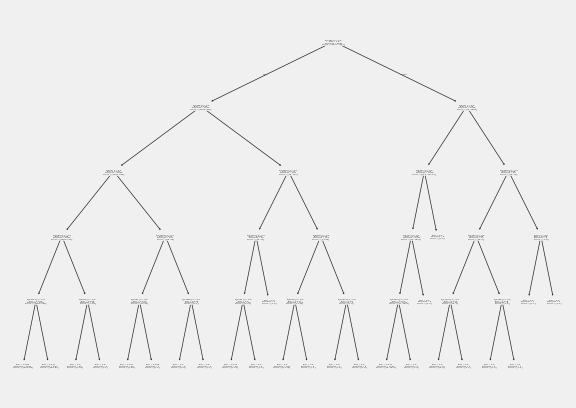

In [45]:
tree.plot_tree(clf)

# **5. Model Evaluation**

**5.1: Performance Metrics**

In [46]:
# Store model accuracies for comparison
accuracies['SVM'] = np.round(acc_svm*100, 2)
accuracies['Decision Tree'] = np.round(acc_dt*100, 2)

# Calculate and print the accuracy scores
print("\n=======Accuracy Scores===========")
acc_svm = metrics.accuracy_score(Y_val, y_pred_svm)
acc_dt = metrics.accuracy_score(Y_val, y_pred_dt)

print(f"Support Vector Machine Accuracy: {acc_svm*100:.2f}%")
print(f"Decision Tree Accuracy: {acc_dt*100:.2f}%")

# Print the confusion matrix
print("\n=======Confusion Matrix===========")
print("Support Vector Machine:\n", metrics.confusion_matrix(Y_val, y_pred_svm))
print("Decision Tree:\n", metrics.confusion_matrix(Y_val, y_pred_dt))

# Additional evaluation metrics
print("\n=======Classification Report===========")
print("Support Vector Machine:\n", metrics.classification_report(Y_val, y_pred_svm, target_names=['Human','AI']))
print("Decision Tree:\n", metrics.classification_report(Y_val, y_pred_dt, target_names=['Human', 'AI']))


=======Accuracy Scores===========
Support Vector Machine Accuracy: 98.39%
Decision Tree Accuracy: 93.03%

=======Confusion Matrix===========
Support Vector Machine:
 [[368   5]
 [  7 366]]
Decision Tree:
 [[354  19]
 [ 33 340]]

=======Classification Report===========
Support Vector Machine:
               precision    recall  f1-score   support

       Human       0.98      0.99      0.98       373
          AI       0.99      0.98      0.98       373

    accuracy                           0.98       746
   macro avg       0.98      0.98      0.98       746
weighted avg       0.98      0.98      0.98       746

Decision Tree:
               precision    recall  f1-score   support

       Human       0.91      0.95      0.93       373
          AI       0.95      0.91      0.93       373

    accuracy                           0.93       746
   macro avg       0.93      0.93      0.93       746
weighted avg       0.93      0.93      0.93       746



**5.2: Model Comparison**

Support Vector Machine: ROC AUC=0.999
Decision Tree: ROC AUC=0.948


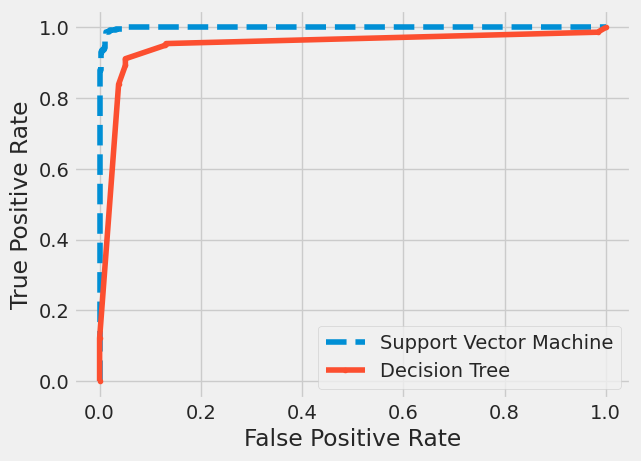

In [52]:
import matplotlib.pyplot as plt
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
svm_probs = final_svc.predict_proba(X_val_svm4)
dt_probs = clf.predict_proba(X_val_dt4)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
dt_probs = dt_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(Y_val, svm_probs)
dt_auc = roc_auc_score(Y_val, dt_probs)
# Store scores for comparison
roc_auc['SVM'] = np.round(svm_auc, 3)
roc_auc['Decision Tree'] = np.round(dt_auc, 3)
# summarize scores
print('Support Vector Machine: ROC AUC=%.3f' % (svm_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(Y_val, svm_probs)
dt_fpr, dt_tpr, _ = roc_curve(Y_val, dt_probs)
# plot the roc curve for the model
plt.plot(svm_fpr, svm_tpr, linestyle='--', label='Support Vector Machine')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [53]:
# Create comparison table
comparison_table = pd.DataFrame({
    'Model': ['Support Vector Machine', 'Decision Tree'],
    'Accuracy': [accuracies['SVM'], accuracies['Decision Tree']],
    'ROC AUC': [roc_auc['SVM'], roc_auc['Decision Tree']]
})
print(comparison_table)

                    Model  Accuracy  ROC AUC
0  Support Vector Machine     98.39    0.999
1           Decision Tree     93.03    0.948


As shown above, the Support Vector Machine (SVM) model performs better than the Decision Tree model. It shows a higher accuracy and lower false positive rate. From the f1-score and recall statistics, we can see that the Decision Tree model struggled to predict AI-written essays than human-written essays, indicated by it's lower scores in those categories. Whereas, the SVM model performed steadily in both scenarios.

**5.3: Error Analysis**

In [54]:
# Get the original index of the validation set
y_val_index = Y_val.index

# Iterate through the indices of Y_val and compare with predictions
# Use the original index to access Y_val and the sequential position i to access y_pred_svm
indices = [y_val_index[i] for i in range(len(Y_val)) if Y_val.iloc[i] != y_pred_svm[i]]

# Use the collected original indices to select rows from the original training DataFrame
wrong_predictions_svm = df_train.loc[indices,:]
print(len(wrong_predictions_svm))

12


In [55]:
wrong_predictions_svm

,essay,label,essay_len,clean_essay
201,It is often said that all influential TV enter...,0,321,often said influential tv entertainment progra...
2922,"In my opinion, successful people are willing t...",1,181,opinion successful people willing try new thin...
2660,We can‚Äôt group all successful people togethe...,1,166,can‚aot group successful people together every...
379,Social media today is extremely significant to...,0,254,social medium today extremely significant majo...
3525,I completely agree with this statement. I beli...,1,201,completely agree statement believe without tak...
343,In many countries around the world young peopl...,0,368,many country around world young people decide ...
3530,There are many different kinds of people in th...,1,170,many different kind people world lot found suc...
3625,"A wise man once said, ""Knowing a little about ...",1,265,wise man said knowing little everything better...
3414,Trying new things\n\nI believe that people sho...,1,97,trying new thing believe people try new thing ...
1640,I agree that successful people tend to have th...,0,309,agree successful people tend attitude trying n...


As we can see from this table, the SVM model struggled more with human-written essays, falsely identifying 11 human-written essays vs 6 AI-written essays. It seems to falsely identify longer, more formal human-written essays as AI, and less formal AI-written essays as human.

In [56]:
# Get the original index of the validation set
y_val_index = Y_val.index

# Iterate through the indices of Y_val and compare with predictions
# Use the original index to access Y_val and the sequential position i to access y_pred_svm
indices = [y_val_index[i] for i in range(len(Y_val)) if Y_val.iloc[i] != y_pred_dt[i]]

# Use the collected original indices to select rows from the original training DataFrame
wrong_predictions_dt = df_train.loc[indices,:]
print(len(wrong_predictions_dt))

52


In [57]:
wrong_predictions_dt.head(15)

,essay,label,essay_len,clean_essay
3008,"From my perspective, I agree that people shoul...",1,149,perspective agree people take risk try new thi...
2323,"These days, smoking is considered one of the m...",1,249,day smoking considered one harmful habit peopl...
3163,Although some people believe that successful i...,1,152,although people believe successful individual ...
189,The cultural value of engaging with museums an...,0,357,cultural value engaging museum art gallery unq...
2267,You should write at least 250 words. You shoul...,1,268,write least word spend minute task day populat...
2837,We grow up in a society that promotes the myth...,1,166,grow society promotes myth success whether you...
1877,Whether people should be encouraged to pursue ...,1,221,whether people encouraged pursue vocational co...
385,There are various numbers of countries that ar...,0,277,various number country rich economic weath pet...
2213,"Today, English is one of the most widely spoke...",1,317,today english one widely spoken language world...
2348,The impact of colors on human emotions has lon...,1,234,impact color human emotion long fascinated psy...


As we can see here, the Decision Tree model resulted an quite a few more incorrect predictions than the SVM model. It seems to struggle more with AI-written essays.

# **6. Results Discussion**

Predict using test data:

In [58]:
# Instantiate CountVectorizer and fit on training data
vectorizer = CountVectorizer(
    binary=True,        # Use binary features (presence/absence)
    max_features=30000, # Limit vocabulary size for efficiency (30k, same as before)
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=2,          # Ignore terms that appear in less than 2 documents
    max_df=0.95        # Ignore terms that appear in more than 95% of documents
)
X_train = vectorizer.fit_transform(df_train['clean_essay'])
X_test = vectorizer.transform(df_test['clean_essay'])
Y_train = df_train['label']

# Implement Support Vector Machine (SVM)
sc = svm.SVC(probability=True)
sc.fit(X_train, Y_train)

# Make predictions
y_pred_class = sc.predict(X_test)

In [59]:
print(len(y_pred_class))

869


Write results to a csv file:

In [60]:
# create index array
indexes = np.arange(0, 870)

# convert array into dataframe
prediction_df = pd.DataFrame(list(zip(indexes, y_pred_class)), columns=["essay_id", "predicted_label"])

print(prediction_df)

     essay_id  predicted_label
0           0                0
1           1                0
2           2                0
3           3                0
4           4                0
..        ...              ...
864       864                0
865       865                0
866       866                0
867       867                0
868       868                0

[869 rows x 2 columns]


In [61]:
# convert dataframe to csv file
prediction_df.to_csv('Emily_Novak_test_R11798447.csv', index=False)